In [8]:
from osgeo import gdal
import numpy as np
import pandas as pd
import os
#import pandas as pd
import matplotlib.pyplot as plt
import sys
import pygmt
from pyproj import Proj, Geod
import rioxarray

sys.path.append('../Functions')
import TiffTools as tt

%load_ext autoreload
%autoreload 2

In [10]:
folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/'

P = Proj('epsg:32611')
G = Geod(ellps='WGS84')


Creating output file that is 21560P x 15499L.
Processing /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/West/WestdZ-rio.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


Creating output file that is 25061P x 16759L.
Processing /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdX-rio.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 25061P x 16759L.
Processing /Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/EastdY-rio.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


: 

In [11]:
tracedf = pd.read_csv('/Volumes/Extreme Pro/Projects/Garlock/GIS/EastPoints.csv')
# Project to UTM
tracedf['x'], tracedf['y'] = P(tracedf.Lon, tracedf.Lat)
# determine primary orientation of the fault, this will detemine sorting
# 0 is ew, 1 is ns
orient = (0 if tracedf.x.max()-tracedf.x.min() > tracedf.y.max()-tracedf.y.min() else 1)
# Sample crossprofiles south to north if ew, else west to east
sample_dir = ('south-to-north' if orient == 0 else 'west-to-east')
# sort 
by = ('x' if orient == 0 else 'y')
tracedf.sort_values(by=by,inplace=True)
# isolate points
fltpts = tracedf[['Lon','Lat']].values

In [12]:
imlist = [folder+'EWDispStackedEPSG4326.tif',
          folder+'NSDispStackedEPSG4326.tif',
          folder+'UDDispStackedEPSG4326.tif']

In [13]:
# Define crossprofile 
crossLength = 4000
crossSample = 0.5
crossSpacing = 0.5

In [14]:
fillvalue

NameError: name 'fillvalue' is not defined

In [15]:
for image,direct in zip(imlist,['east (m)','north (m)','up (m)']):
    im = rioxarray.open_rasterio(image).astype(np.double)
    # Get mask and Shift data so that the minimum is zero
    fillvalue = im._FillValue
    mask = ((im != fillvalue) & (im < 255 ) & (im != np.nan)).data
    # Rescale so that negative values are shifted up to 0 or greater
    if im.data[mask].min() < 0:
        im.data[mask] -= im.data[mask].min()
    # set nodata to zero
    im.data[~mask] = 0
    #disparr = im.astype(np.double)

    tmp = pygmt.grdtrack(im,points=fltpts,crossprofile=f'{crossLength}e/{crossSample}e/{crossSpacing}e+v“s{sample_dir}”')
    tmp.columns = ['lon','lat','linedist','az',direct]
    if direct.startswith('e'):
        track = tmp
    else: 
        track[direct] = tmp[direct]

track['az'] = np.round(track.az) # Round azimuth to integer, helps with later grouping of trcaks
ntracks = len(track[track.linedist==0]) # number of cross-profiles
nsamp = int(len(track)/ntracks) # Number of samples per cross-profile

trackids = np.repeat(np.arange(ntracks), nsamp)
track['id'] = trackids # id for each crossprofile

del trackids, tmp

track['perpendicular'] = track['north (m)']*np.cos(-1*track.az*np.pi/180)-track['east (m)']*np.sin(-1*track.az*np.pi/180)
track['parallel'] = track['north (m)']*np.sin(-1*track.az*np.pi/180)+track['east (m)']*np.cos(-1*track.az*np.pi/180)

# Rounding to make dataframe smaller
track['lon'] = np.round(track.lon.values,8)
track['lat'] = np.round(track.lat.values,8)
track['linedist'] = np.round(track.linedist,4)
track['east (m)'] = np.round(track['east (m)'],4)
track['north (m)'] = np.round(track['north (m)'],4)
track['up (m)'] = np.round(track['up (m)'],4)
track['parallel'] = np.round(track['parallel'],4)
track['perpendicular'] = np.round(track['perpendicular'],4)

/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,
grdtrack [WARNING]: Some points along your profiles were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,
grdtrack [WARNIN

In [61]:
# Save
save = False
if save == True:
    track.to_csv(folder+'GarlockEastProfilesAll.txt',index=False)
else:
    print('Not saving or overwriting the file')

In [32]:
save = True

In [33]:
# Create sub-files with 10-m along track groups
prof_folder = '/Users/chanagan/Library/CloudStorage/OneDrive-DOI/Projects/Garlock/Deformation/East/micmac/splitProfiles/'
nprof = 200 # number of profiles per file
nfiles = int(np.ceil(len(np.unique(track.id))/nprof)) # number of files
if save == True:
    for i in range(0,nfiles):
        track[(track.id >=  i*nprof) & (track.id < i*nprof+nprof)].to_csv(prof_folder+f'GarlockEastProfiles{int(i*nprof)}to{int(i*nprof+nprof)}.txt',index=False)
else:
    print('Not saving or overwriting the file')

In [53]:
#track.to_hdf(folder+'GarlockEastProfilesAll.h5', key='df', mode='w',complevel=9) 

In [22]:
pdf

,lon,lat,linedist,az,east (m),north (m),up (m),id,parallel,perpendicular
800100,-117.023279,35.583064,-1997.1372,355.0,1.6644,1.1949,16.9372,100,1.7622,1.0453
800101,-117.023279,35.583069,-1996.6379,355.0,1.6669,1.1946,16.8770,100,1.7646,1.0448
800102,-117.023280,35.583073,-1996.1386,355.0,1.6657,1.1925,16.8259,100,1.7633,1.0428
800103,-117.023280,35.583078,-1995.6394,355.0,1.6659,1.1910,16.7588,100,1.7633,1.0413
800104,-117.023280,35.583082,-1995.1401,355.0,1.6518,1.1848,16.7604,100,1.7488,1.0363
...,...,...,...,...,...,...,...,...,...,...
808096,-117.026886,35.618899,1995.1454,355.0,NaN,NaN,NaN,100,NaN,NaN
808097,-117.026887,35.618904,1995.6446,355.0,NaN,NaN,NaN,100,NaN,NaN
808098,-117.026887,35.618908,1996.1439,355.0,NaN,NaN,NaN,100,NaN,NaN
808099,-117.026888,35.618913,1996.6432,355.0,NaN,NaN,NaN,100,NaN,NaN


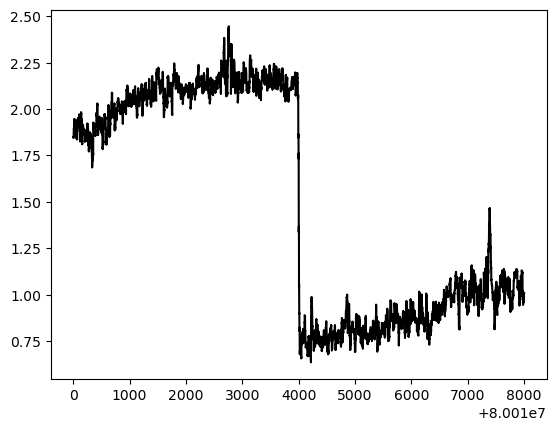

In [31]:
pdf = track[track.id == 10000]

plt.plot(pdf['parallel'],c='black')


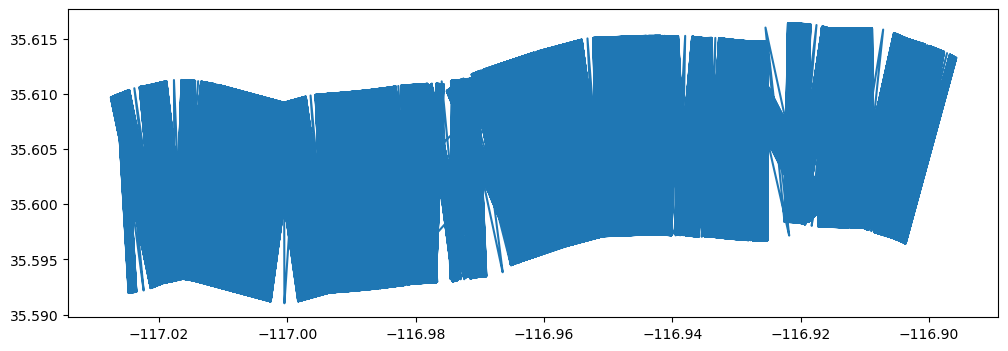

In [164]:
plt.figure(figsize=(12,4))
plt.plot(tmp.lon,tmp.lat)

In [177]:
tmp

,lon,lat,linedist,az,val,stackmean,stdev
0,-117.024731,35.591991,-998.569262,355.320450,3.479599,3.371860,0.199704
1,-117.024731,35.591995,-998.069977,355.320450,3.479032,3.372163,0.199444
2,-117.024732,35.592000,-997.570693,355.320450,3.478512,3.372467,0.199185
3,-117.024732,35.592004,-997.071409,355.320449,3.478042,3.372771,0.198929
4,-117.024732,35.592009,-996.572124,355.320449,3.477621,3.373074,0.198677
...,...,...,...,...,...,...,...
92835198,-116.895794,35.613227,996.931077,20.898948,NaN,2.475151,0.234705
92835199,-116.895792,35.613231,997.430542,20.898949,NaN,2.475167,0.234791
92835200,-116.895790,35.613235,997.930007,20.898950,NaN,2.475162,0.234872
92835201,-116.895788,35.613239,998.429472,20.898952,NaN,2.475160,0.234954


In [191]:
tmp.iloc[::int(proflen)]

,lon,lat,linedist,az,val,stackmean,stdev
0,-117.024731,35.591991,-998.569262,355.320450,3.479599,3.37186,0.199704
4001,-117.024725,35.591991,-998.569262,355.320453,3.481037,3.37186,0.199704
8002,-117.024720,35.591992,-998.569262,355.320456,3.482451,3.37186,0.199704
12003,-117.024714,35.591992,-998.569262,355.320459,3.483839,3.37186,0.199704
16004,-117.024709,35.591992,-998.569262,355.320463,3.485200,3.37186,0.199704
...,...,...,...,...,...,...,...
92815198,-116.903698,35.596447,-998.927696,20.894348,3.061348,3.37186,0.199704
92819199,-116.903692,35.596445,-998.927696,20.894351,3.059313,3.37186,0.199704
92823200,-116.903687,35.596443,-998.927696,20.894354,3.057309,3.37186,0.199704
92827201,-116.903682,35.596442,-998.927696,20.894357,3.055340,3.37186,0.199704


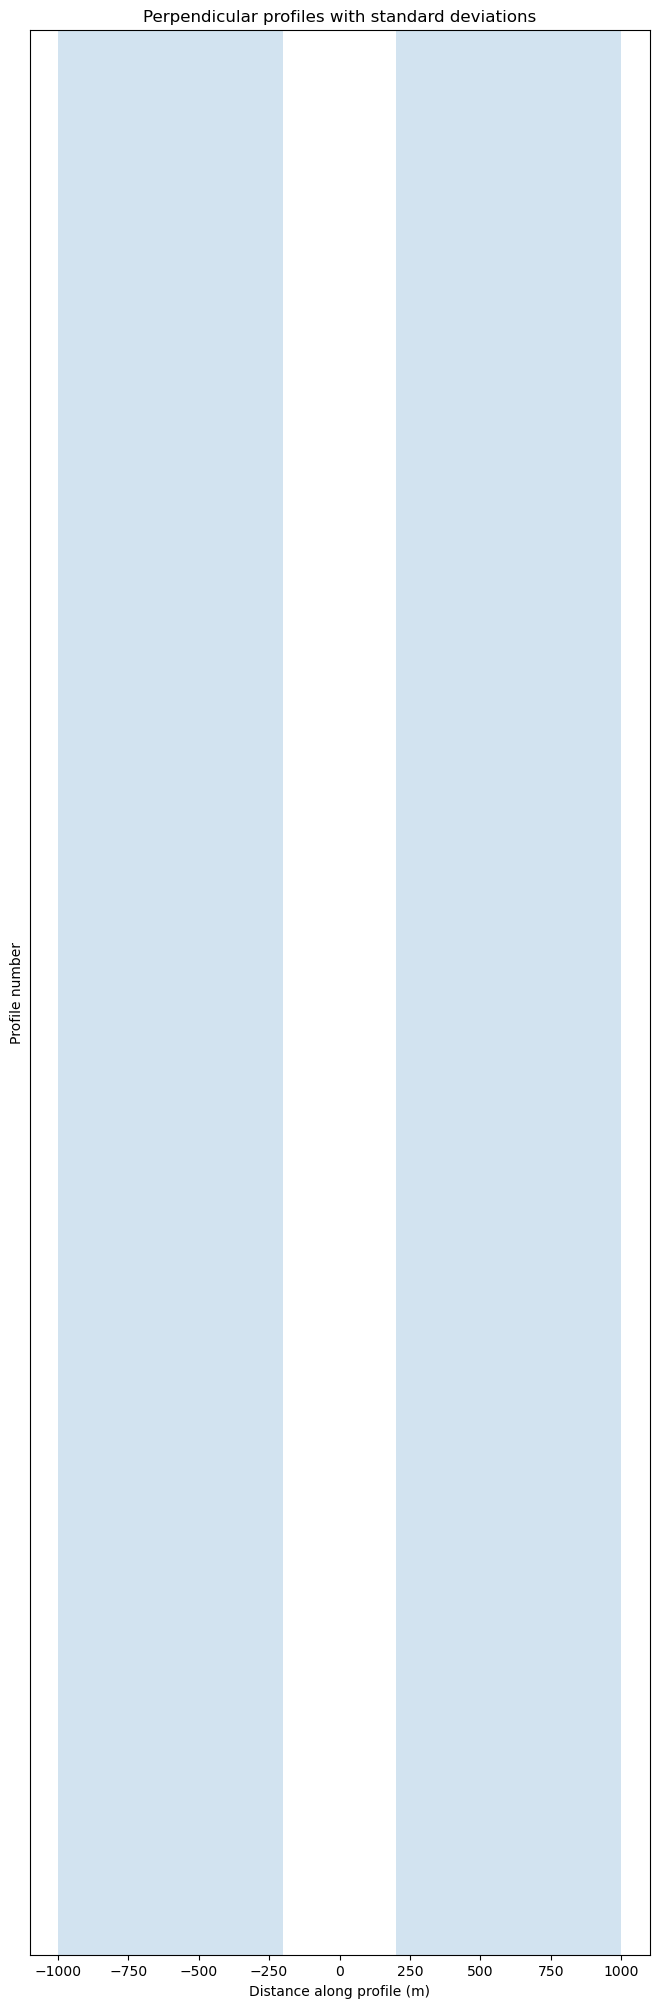

In [192]:
## Good one!tmp.iloc[121*100:121*221+121]
track = tmp
shift = 1
# Profile taken at 
distance = [200,1000]
bmin, bmax = int(distance[0]/crossSample),int(distance[1]/crossSample)#150,250
proflen = np.floor(crossLength/crossSample)+1
meandisp = {'perp':[]}#,'par':[],'vert':[]}
stdev = {'perp':[]}#,'par':[],'vert':[]}
trackdist = {'perp':[]}#,'par':[],'vert':[]}

for track, j, title in zip([track], meandisp.keys(),['Perpendicular']):
    plt.figure(figsize=(8,25))
    plt.title(f'{title} profiles with standard deviations')

    yticks = []
    yticklabels = []
    last_y = None  # To track the y-position of the last label
    
    for i in range(0,len(track[track.linedist==0])):
        prof = track.iloc[int(i*proflen):int(proflen+i*proflen)]
        print(i,prof[prof.linedist > distance[0]].val.mean()-prof[prof.linedist <= -distance[0]].val.mean())
        
        y_position = (i + 1)  # Ensure y_position is starting from 1 through 25
        profile_line = prof.val - prof.val.iloc[0] + y_position * shift
        plt.plot(prof.linedist, profile_line)
        plt.fill_between(prof.linedist, profile_line - prof.stdev, profile_line + prof.stdev, alpha=0.2)

        # Determine the annotation y-position to avoid overlap
        label_y = profile_line.iloc[-1]
        if last_y is not None and abs(label_y - last_y) < 0.5:  # Adjust this threshold as needed
            label_y += 0.8  # Shift the label up by 0.5 units if too close to the previous one

        last_y = label_y  # Update last_y to the current label's y-position

        yticks.append(y_position * shift)
        yticklabels.append(str(int(y_position)))

    plt.axvspan(distance[0],distance[1],alpha=0.2)
    plt.axvspan(-distance[0],-distance[1],alpha=0.2)
    plt.yticks(yticks, yticklabels)
    plt.xlabel('Distance along profile (m)')
    plt.ylabel('Profile number')


In [9]:
for image in imlist:
    im = rioxarray.open_rasterio(image)
    # Get mask and Shift data so that the minimum is zero
    fillvalue = im._FillValue
    mask = ((im != fillvalue) & (im < 255 ) & (im != np.nan)).data
    # Rescale so that negative values are shifted up to 0 or greater
    if im.data[mask].min() < 0:
        im.data[mask] -= im.data[mask].min()
    # set nodata to zero
    im.data[~mask] = 0
    disparr = im.astype(np.double)
    # Create crossprofiles along a line
    # 2 endpoints provided in pts
    # crossprofiles are length/sample spacing along profile/space between each profile
    # e is the unit notation for meter
    # stack a means the mean value (a is average) appended to each profile (+a), +da appends standard deviation too
    # Output is lon, lat, dist, azimuth,value of grid, mean of stack, stdev of stack
    track = pd.DataFrame(columns=['id','lon','lat','linedist','az','val','stackmean','stdev'])
    for i in range(0,len(pts)-1):
        tmp = pygmt.grdtrack(disparr,points=np.array([pts[i],pts[i+1]]),binary='id',
                                crossprofile=f'{crossLength}e/{crossSample}e/{crossSpacing}e',stack='a+a+dm')
        tmp.columns = ['lon','lat','linedist','az','val','stackmean','stdev']
        tmp['id'] = np.ones(len(tmp))*i
        # replace lon of individual profile with center of stack
        #tmp['lon'] = np.ones(len(tmp))*tmp['lon'][tmp.linedist == 0].median()
        #tmp['lat'] = np.ones(len(tmp))*tmp['lat'][tmp.linedist == 0].median()
        track = pd.concat([track,tmp],axis=0,ignore_index=True)
    #track.drop(columns=['val'],inplace=True)
    print('Hi')

    #if image is imlist[0]:
    #    #track.to_csv('/Users/chanagan/Desktop/DGStereo/TienShan/micmac/PerpendicularProfiles.txt')
    #elif image is imlist[1]:
    #    #track.to_csv('/Users/chanagan/Desktop/DGStereo/TienShan/micmac/ParallelProfiles.txt')
    #elif image is imlist[2]:
        #track.to_csv('/Users/chanagan/Desktop/DGStereo/TienShan/micmac/VerticalProfiles.txt')


/Users/chanagan/miniconda3/envs/pygmt/lib/python3.12/site-packages/pygmt/src/grdtrack.py:309: RuntimeWarning: Input image has dtype: float64 which is unsupported, and may result in an incorrect output. Please recast image to a uint8 dtype and/or scale to 0-255 range, e.g. using a histogram equalization function like skimage.exposure.equalize_hist.
  lib.virtualfile_in(check_kind="raster", data=grid) as vingrd,
grdtrack [WARNING]: Some points along your profiles were outside the grid domain(s).
grdtrack [WARNING]: Some input points were outside the grid domain(s).
/var/folders/zn/w54gt7k11csfs1n4z8r3xccsyqhmjz/T/ipykernel_67729/2931332651.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  track = pd.concat([track,tmp],axis=0,ignore_index=T

Hi


In [13]:
meandisp.keys()

dict_keys(['perp'])

AttributeError: 'DataFrame' object has no attribute 'id'

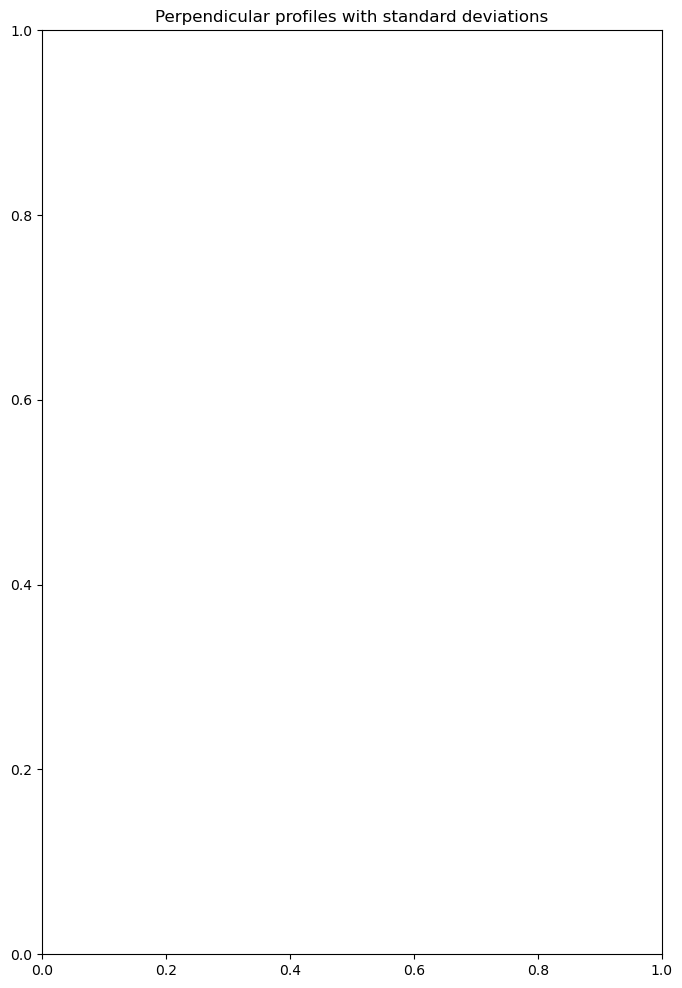

In [61]:
## Good one!
track = tmp
shift = 1
# Profile taken at 
distance = [300,500]
bmin, bmax = int(distance[0]/crossSample),int(distance[1]/crossSample)#150,250
meandisp = {'perp':[]}#,'par':[],'vert':[]}
stdev = {'perp':[]}#,'par':[],'vert':[]}
trackdist = {'perp':[]}#,'par':[],'vert':[]}
centerlats = {'perp':[]}#,'par':[],'vert':[]}
centerlons = {'perp':[]}#,'par':[],'vert':[]}
for track, j, title in zip([track], meandisp.keys(),['Perpendicular']):
    plt.figure(figsize=(8,12))
    plt.title(f'{title} profiles with standard deviations')

    yticks = []
    yticklabels = []
    last_y = None  # To track the y-position of the last label
    
    for i in track.id.unique():
        prof = track[track.id==i]
        print(i,prof[prof.linedist > distance[0]].stackmean.mean()-prof[prof.linedist <= -distance[0]].stackmean.mean())
        meandisp[j].append(prof[prof.linedist > distance[0]].stackmean.mean()-prof[prof.linedist <= -distance[0]].stackmean.mean())
        stdev[j].append(np.std(prof[prof.linedist > distance[0]].stackmean.values-prof[prof.linedist <= -distance[0]].stackmean.values))
        trackdist[j].append(i+1)
        if i == np.median(track.id.unique()):
            centerlons[j].append(prof.lon.unique())
            centerlats[j].append(prof.lat.unique())
        
        y_position = (i + 1)  # Ensure y_position is starting from 1 through 25
        profile_line = prof.stackmean - prof.stackmean.iloc[0] + y_position * shift
        plt.plot(prof.linedist, profile_line)
        plt.fill_between(prof.linedist, profile_line - prof.stdev, profile_line + prof.stdev, alpha=0.2)

        # Determine the annotation y-position to avoid overlap
        label_y = profile_line.iloc[-1]
        if last_y is not None and abs(label_y - last_y) < 0.5:  # Adjust this threshold as needed
            label_y += 0.8  # Shift the label up by 0.5 units if too close to the previous one

        # Annotate the meandisp near the right edge of the plot, with the span in parentheses
        plt.annotate(f'{meandisp[j][int(i)]:.2f} m',
                     xy=(prof.linedist.max(), profile_line.iloc[-1]),  # Position at the right edge of the profile
                     xytext=(prof.linedist.max() + 50, label_y),  # Adjusted label position to avoid overlap
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
                     fontsize=10, color='black', ha='left')

        last_y = label_y  # Update last_y to the current label's y-position

        yticks.append(y_position * shift)
        yticklabels.append(str(int(y_position)))

    plt.axvspan(distance[0],distance[1],alpha=0.2)
    plt.axvspan(-distance[0],-distance[1],alpha=0.2)
    plt.yticks(yticks, yticklabels)
    plt.xlabel('Distance along profile (m)')
    plt.ylabel('Profile number')
    shift = 1

In [22]:
tmp

,lon,lat,linedist,az,val,stackmean,stdev,id
0,-117.023499,35.592073,-998.569268,355.321167,NaN,0.0,NaN,49.0
1,-117.023589,35.592969,-898.712400,355.321167,NaN,0.0,NaN,49.0
2,-117.023679,35.593865,-798.855520,355.321114,NaN,0.0,NaN,49.0
3,-117.023769,35.594762,-698.998626,355.321062,NaN,0.0,NaN,49.0
4,-117.023860,35.595658,-599.141719,355.321009,NaN,0.0,NaN,49.0
5,-117.023950,35.596554,-499.284799,355.320957,NaN,0.0,NaN,49.0
6,-117.024040,35.597451,-399.427866,355.320904,NaN,0.0,NaN,49.0
7,-117.024130,35.598347,-299.570919,355.320852,NaN,0.0,NaN,49.0
8,-117.024221,35.599243,-199.713959,355.320799,NaN,0.0,NaN,49.0
9,-117.024311,35.600140,-99.856986,355.320747,NaN,0.0,NaN,49.0


In [33]:
np.sqrt(tracedf.iloc[-1].x**2+tracedf.iloc[-1].y**2) -np.sqrt(tracedf.iloc[-2].x**2+tracedf.iloc[-2].y**2)

-22.982203418854624